In [1]:
import pandas as pd
import numpy as np
import time
from dateutil.parser import parse
from bs4 import BeautifulSoup
from nytimesarticle import articleAPI

In [279]:
import matplotlib.pyplot as plt
%matplotlib inline

# getting data

In [2]:
api = articleAPI('a9868c476911adea9d3b10ea.....')
def get_articles(year):
    
    start = ['0101','0201','0301','0401','0501','0601','0701','0801','0901','1001','1101','1201']
    end = ['0131','0228','0331','0430','0531','0630','0731','0831','0930','1031','1130','1231']
    df = pd.DataFrame()
    for i in range(12):
        #NYT limits pager to first 100 pages, but for each month, there will rarely be 100 pages
        for k in range(0,100): 
            articles = api.search(q = 'San Francisco',
                   begin_date = year + start[i],
                   end_date = year + end[i],
                   sort='oldest',
                   page = str(k))
            if len(articles['response']['docs']) == 0:
                pass
            else:
                docs = articles['response']['docs']
                for j in range(len(docs)):
                    text = docs[j]
                    data = {}
                    #get id, headline, lead paragraph and datetime of the article
                    data['id'] = text['_id']
                    try:
                        data['headline'] = text['headline']['main'].encode('utf-8').decode('unicode_escape').encode('ascii','ignore')
                    except AttributeError:
                        data['headline'] = ' '
                    try:
                        data['lead'] = text['lead_paragraph'].encode('utf-8').decode('unicode_escape').encode('ascii','ignore')
                    except AttributeError:
                        data['lead'] = ' '
                    try:
                        data['datetime'] = parse(text['pub_date'])
                    except AttributeError:
                        data['datetime'] = float('NaN')
                    #get url and web scraping the whole article 
                    try:
                        data['url'] = text['web_url'].encode('utf-8')
                        url_soup = text['web_url'].encode('utf-8')
                        response2 = requests.get(url_soup)
                        raw_html2 = response2.text
                        s = BeautifulSoup(raw_html2)
                        if s.find('p', {'itemprop': 'articleBody'}) is not None:  
                            paragraphs = s.findAll('p', {'itemprop': 'articleBody'})
                            article = ' '.join([p.text for p in paragraphs])
                        elif s.find('nyt_text') is not None:  
                            article = s.find('nyt_text').text
                        elif s.find('div', {'id': 'mod-a-body-first-para'}) is not None:  
                            article = s.find('div', {'id': 'mod-a-body-first-para'}).text
                            article += s.find('div', {'id': 'mod-a-body-after-first-para'}).text
                        else:  
                            if s.find('p', {'class': 'story-body-text'}) is not None:
                                paragraphs = s.findAll('p', {'class': 'story-body-text'})
                                article = ' '.join([p.text for p in paragraphs])
                            else:
                                story = float('NaN')
                        data['article'] = article.encode('utf-8').decode('unicode_escape').encode('ascii','ignore')
                    except AttributeError:
                        data['url'] = float('NaN')
                    
                    df = df.append(data, ignore_index=True)
    return df

In [ ]:
df1 = get_articles('2015')
df2 = get_articles('2014')
df3 = get_articles('2013')
df = df1.append(df2, ignore_index=True)
df = df.append(df3, ignore_index=True)
df.to_csv('sf_all.csv')

# Preprocessing

In [32]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import re

In [273]:
df = pd.read_csv('new_york_times/sf_all.csv')
df = df.dropna(subset=['story','datetime'])

In [370]:
def token_process(doc):
    #stop words and updates
    stop_en = stopwords.words('english') + [u',',u'.',u'?',u'!',u':',u';', u')', u'(',u'[',u']',u'{',u'}',u'%',u'@',
                                           u'san',u'francisco',u'san francisco',u'new',u'tr',u'th',u'to',u'on',u'of',u'mr',
                                           u'monday','tuesday',u'wednesday',u'thursday',u'friday',u'saturday',u'sunday','want','befor','becaus'
                                           u'said',u'ms',u'york',u'say',u'could',u'q',u'got',u'found',u'began','|',"''","'s","``","--",
                                           'mr','year','would','one','way','l','ms.','$','mr.','dr.','get','before','like','know','day','because',
                                           '"','see','look','dont','im','&','b','also','de','la','el','en','un','two','al','su','es','lo','se']
    #stemming
    stemmer = SnowballStemmer("english")
    #tokenize
    tokens = [w.strip().decode('utf8') for sent in sent_tokenize(doc) for w in word_tokenize(sent)] if doc else None
    #filter numbers
    num_pat = re.compile(r'^(-|\+)?(\d*).?(\d+)')
    tokens = filter(lambda x: not num_pat.match(x), tokens)
    #filter dates
    date_pat =  re.compile(r'^(\d{1,2})(/|-)(\d{1,2})(/|-)(\d{2,4})$')
    tokens = filter(lambda x: not date_pat.match(x), tokens)
    #use stemmer
    lemmatized_tokens = map(lambda x: stemmer.stem(x), tokens)
    #filter out empty tokens and stopwords
    lemmatized_tokens = filter(lambda x: x and x.strip() not in stop_en, lemmatized_tokens)

    #x = ' '.join(lemmatized_tokens)
    return lemmatized_tokens

In [371]:
#token process
f = lambda x: float('NaN') if len(x) == 0 else x
df['processed'] = df.story.apply(token_process)
df['processed'] = df.processed.apply(f)
df = df.dropna()

# LDA

In [59]:
import gensim
from gensim.matutils import Sparse2Corpus
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary, MmCorpus

In [276]:
#create word dictionary and corpus
dictionary = Dictionary(df.processed)
#get rid of the words that too rare or in most of the documents
dictionary.filter_extremes(no_below=10, no_above=0.75, keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in df.processed]

In [ ]:
#train test split
train_size = int(round(len(corpus)*0.8))
train_index = sorted(random.sample(xrange(len(corpus)), train_size))
test_index = sorted(set(xrange(len(corpus)))-set(train_index))
train_corpus = [corpus[i] for i in train_index]
test_corpus = [corpus[j] for j in test_index]

In [ ]:
#calculate the log perplexity of test set for different number of topics
topic_nums = [2,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,90,100,110,120,130,140,150,160,170,180,190,200]
perplexity_list = []
for i in topic_nums:
    lda = models.LdaModel(train_corpus, id2word=dictionary, num_topics=i)
    perplexity_list += [lda.log_perplexity(test_corpus)]

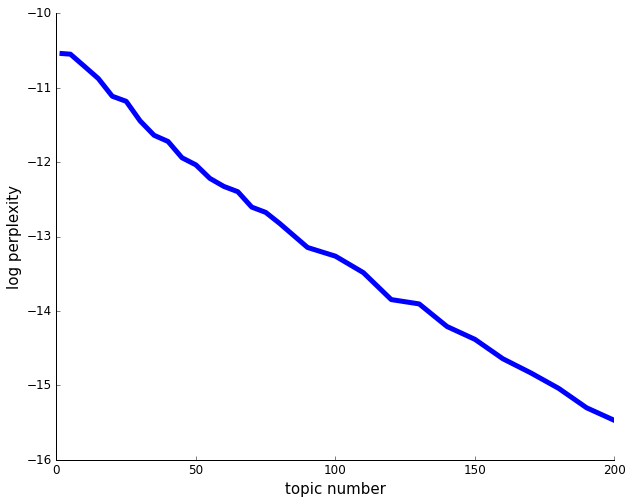

In [289]:
#plot the log perplexity
plt.figure(figsize=(10,8))
ax = plt.subplot(111)
ax.plot(topic_nums, perplexity_list, linewidth=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(top='off', right='off') 
ax.tick_params(labelsize=12)
ax.set_xlabel('topic number', fontsize=15)
ax.set_ylabel('log perplexity', fontsize=15)

In [ ]:
#find the topics using pyLDAvis
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [410]:
#update the stop words and change filter_extremes during the process
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=None)
dictionary.compactify()
corpus = [dictionary.doc2bow(doc) for doc in df.processed]
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=10)

In [411]:
#visualize
vis_data = gensimvis.prepare(lda, corpus, dictionary)
pyLDAvis.display(vis_data)

In [413]:
lda.print_topics(num_topics=10, num_words=10)

[(0,
  u'0.008*art + 0.006*street + 0.005*museum + 0.004*artist + 0.004*show + 0.003*book + 0.003*paint + 0.003*citi + 0.003*american + 0.003*world'),
 (1,
  u'0.008*music + 0.007*p.m. + 0.005*street + 0.005*perform + 0.003*theater + 0.003*show + 0.003*play + 0.003*director + 0.003*art + 0.003*center'),
 (2,
  u'0.005*patient + 0.004*hospit + 0.004*california + 0.004*health + 0.004*medic + 0.004*food + 0.004*state + 0.003*studi + 0.003*research + 0.003*becaus'),
 (3,
  u'0.011*compani + 0.006*googl + 0.005*servic + 0.005*citi + 0.004*data + 0.004*car + 0.004*busi + 0.004*technolog + 0.004*user + 0.004*map'),
 (4,
  u'0.017*game + 0.011*week + 0.010*team + 0.009*season + 0.008*yard + 0.008*play + 0.006*pass + 0.006*vs. + 0.005*quarterback + 0.005*touchdown'),
 (5,
  u'0.008*presid + 0.007*group + 0.006*state + 0.006*compani + 0.006*part + 0.006*agenc + 0.005*execut + 0.005*unit + 0.005*offic + 0.005*director'),
 (6,
  u'0.014*game + 0.009*run + 0.009*hit + 0.008*inning + 0.007*season + 

In [414]:
#look at topics using word cloud
from wordcloud import WordCloud

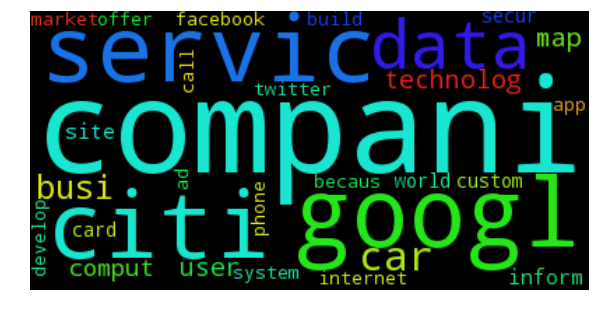

In [417]:
#get terms in the selected topic
topic_terms = lda.get_topic_terms(3, topn=30)
#get the words according to the trem numbers and create a list of lists
w_cloud = {}
w_cloud['words'] = [dictionary[e[0]] for e in topic_terms]
w_cloud['freq'] = [e[1] for e in topic_terms]
tok = pd.DataFrame(w_cloud).values.tolist()
tok = [[e[1], e[0]] for e in tok]

wordcloud = WordCloud().generate_from_frequencies(tok)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud)   
plt.axis("off")
plt.show()

In [342]:
#view the network of topics and terms
import networkx as nx

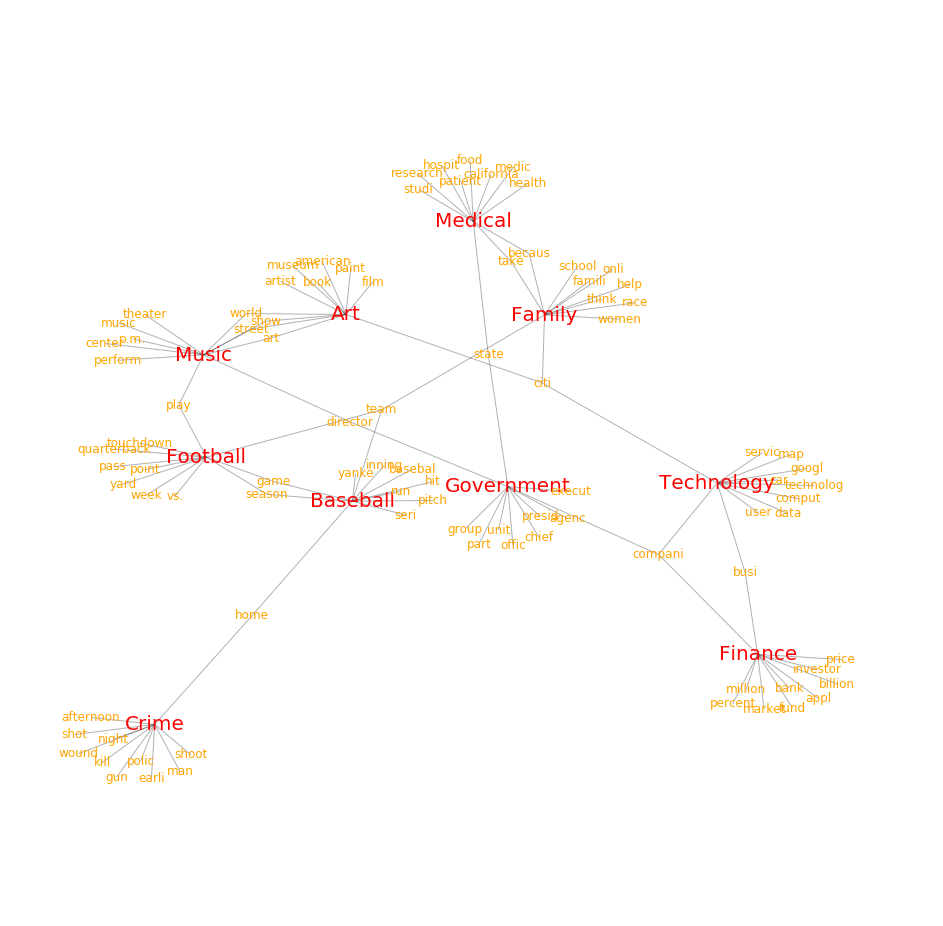

In [529]:
def graph_terms_to_topics(lda, num_terms=10):
    #topic names
    t = ['Art', 'Music','Medical','Technology','Football','Government','Baseball','Family','Finance','Crime']
    #create a new graph and size it
    G = nx.Graph()
    plt.figure(figsize=(16,16))
    # generate the edges
    for i in range(0, lda.num_topics):
        topicLabel = t[i]
        terms = [term for term, val in lda.show_topic(i, num_terms+1)]
        for term in terms:
            G.add_edge(topicLabel, term, edge_color='red')
    
    pos = nx.spring_layout(G) # positions for all nodes
    
    #plot topic labels and terms labels separately to have different colours
    g = G.subgraph([topic for topic, _ in pos.items() if topic in t])
    nx.draw_networkx_labels(g, pos, font_size=20, font_color='r')
    g = G.subgraph([term for term, _ in pos.items() if str(term) not in t])
    nx.draw_networkx_labels(g, pos, font_size=12, font_color='orange')
    
    #plot edges
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), alpha=0.3)

    plt.axis('off')
    plt.show()

graph_terms_to_topics(lda, num_terms=10)

In [530]:
#plot the evolution of topics vs. time
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]

In [531]:
num_t = 11
topics = range(num_t)
d = {}#dict.fromkeys(range(30))
for doc in lda_docs:
    l = [x[0] for x in doc]
    for topic in doc:
        if topic[0] in d.keys():
            d[topic[0]] += [topic[1]]
        else:
            d[topic[0]] = [topic[1]]
    for i in range(num_t):
        if i in l:
            pass
        else:
            if i in d.keys():
                d[i] += [0]
            else:
                d[i] = [0]
d['datetime'] = df.datetime                

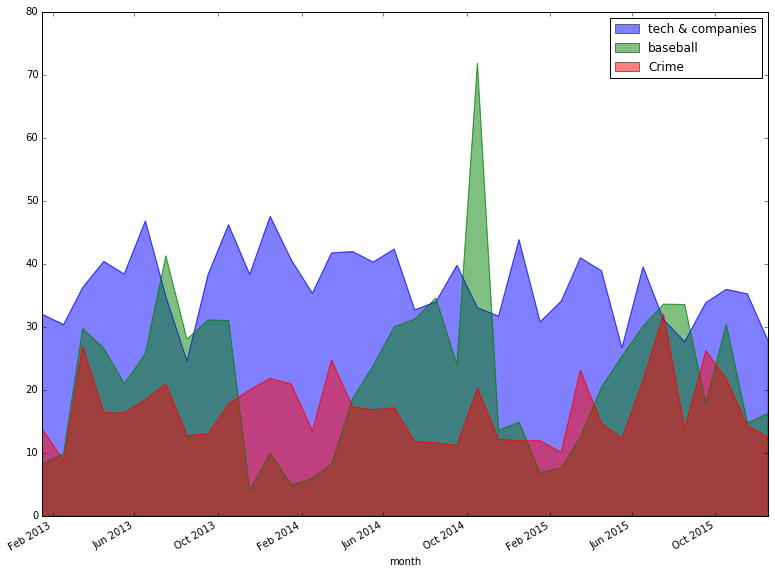

In [538]:
a_t = pd.DataFrame(d)

f = lambda x: parse(str(parse(x).year)+' ' + str(parse(x).month))
a_t['month'] = a_t.datetime.apply(f)
a_tt = a_t.groupby('month').sum()

df1 = a_tt[[3,6,9]]
df1.columns = [['technology','baseball','Crime']]

df1.plot.area(figsize=(13,10),stacked=False)